# Style Transfer with Deep Neural Networks


In this notebook, we’ll *recreate* a style transfer method that is outlined in the paper, [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) in PyTorch.

In this paper, style transfer uses the features found in the 19-layer VGG Network, which is comprised of a series of convolutional and pooling layers, and a few fully-connected layers. In the image below, the convolutional layers are named by stack and their order in the stack. Conv_1_1 is the first convolutional layer that an image is passed through, in the first stack. Conv_2_1 is the first convolutional layer in the *second* stack. The deepest convolutional layer in the network is conv_5_4.

<img src='https://github.com/iceman011/deep-learning-v2-pytorch/blob/master/style-transfer/notebook_ims/vgg19_convlayers.png?raw=1' width=80% />

### Separating Style and Content

Style transfer relies on separating the content and style of an image. Given one content image and one style image, we aim to create a new, _target_ image which should contain our desired content and style components:
* objects and their arrangement are similar to that of the **content image**
* style, colors, and textures are similar to that of the **style image**

An example is shown below, where the content image is of a cat, and the style image is of [Hokusai's Great Wave](https://en.wikipedia.org/wiki/The_Great_Wave_off_Kanagawa). The generated target image still contains the cat but is stylized with the waves, blue and beige colors, and block print textures of the style image!

<img src='https://github.com/iceman011/deep-learning-v2-pytorch/blob/master/style-transfer/notebook_ims/style_tx_cat.png?raw=1' width=80% />

In this notebook, we'll use a pre-trained VGG19 Net to extract content or style features from a passed in image. We'll then formalize the idea of content and style _losses_ and use those to iteratively update our target image until we get a result that we want. You are encouraged to use a style and content image of your own and share your work on Twitter with @udacity; we'd love to see what you come up with!

In [13]:
# How to run a Dash app in Google Colab

## Requirements
import os

### Install ngrok
if not os.path.exists('./ngrok-stable-linux-amd64.zip'):
  !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
  !unzip ngrok-stable-linux-amd64.zip

### Install Dash
#!pip uninstall dash
!pip install dash #==0.31.1  # The core dash backend
!pip install dash-html-components #==0.13.2  # HTML components
!pip install dash-core-components #==0.39.0  # Supercharged components
!pip install dash-table #==3.1.7  # Interactive DataTable component (new!)

In [0]:
#ORGINAL LINK IS BELOW
#https://github.com/iceman011/deep-learning-v2-pytorch/blob/master/style-transfer/Style_Transfer_Solution.ipynb

# import resources
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models
import time
from io import BytesIO as _BytesIO


##############################################
# PAREPARE VGG PRETRAINED MODEL
############################################
def prepare_model():
  # get the "features" portion of VGG19 (we will not need the "classifier" portion)
  vgg = models.vgg19(pretrained=True).features

  # freeze all VGG parameters since we're only optimizing the target image
  for param in vgg.parameters():
      param.requires_grad_(False)
  print('Finished Preparing Model...')
  return vgg

##########################################
# GET FEATURES FROM VGG MODEL
##############################################
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

#############################################
# BUILD GRAM MATRIX
#############################################
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

###############################################
# iniTIALIZE WEIGHTS
###############################################
def init_weights(style_weights=None,content_weight =1, style_weight=1e6):
  # weights for each style layer 
  # weighting earlier layers more will result in *larger* style artifacts
  # notice we are excluding `conv4_2` our content representation
  if not style_weights:
    style_weights = {'conv1_1': 1.,
                    'conv2_1': 0.75,
                    'conv3_1': 0.2,
                    'conv4_1': 0.2,
                    'conv5_1': 0.2}

  content_weight = content_weight # alpha
  style_weight = style_weight  # beta
  return style_weights , content_weight , style_weight

#####################################
# BUILD CONENT & STYLE FEATURES
######################################
def build_features(content ,style,model):
  # get content and style features only once before training
  content_features = get_features(content, model)
  style_features = get_features(style, model)
  return content_features , style_features

#####################################
# CALC GRAMS OF STYLE FEATURES
######################################
def calc_style_grams(style_features):
  # calculate the gram matrices for each layer of our style representation
  style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
  return style_grams

#####################################
# LOAD IMAGE FROM LOCAL OR WEB ADSRESS
######################################
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image      

##########################################
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
##########################################
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image


##########################################
# helper function to convert PIL image to base64 for HTML display
##########################################
def pil_to_b64(im, enc_format='png', verbose=True, **kwargs):
    """
    Converts a PIL Image into base64 string for HTML displaying
    :param im: PIL Image object
    :param enc_format: The image format for displaying. If saved the image will have that extension.
    :return: base64 encoding
    """
    t_start = time.time()

    buff = _BytesIO()
    im.save(buff, format=enc_format, **kwargs)
    encoded = base64.b64encode(buff.getvalue()).decode("utf-8")

    t_end = time.time()
    if verbose:
        print(f"PIL converted to b64 in {t_end - t_start:.3f} sec")

    return encoded


##########################################
# helper function to convert numpy image to base64 for HTML display
##########################################
def numpy_to_b64(np_array, enc_format='png', scalar=True, **kwargs):
    """
    Converts a numpy image into base 64 string for HTML displaying
    :param np_array:
    :param enc_format: The image format for displaying. If saved the image will have that extension.
    :param scalar:
    :return:
    """
    # Convert from 0-1 to 0-255
    if scalar:
        np_array = np.uint8(255 * np_array)
    else:
        np_array = np.uint8(np_array)

    im_pil = Image.fromarray(np_array)

    return pil_to_b64(im_pil, enc_format, **kwargs)

#######################################
# DEBUG INTERMEDIATE STATES
###########################################
def view_target_featuers(target_featuers):
  fig = plt.figure(figsize=(10, 6))
  i = 0
  for layer_name in target_features:
    layer = target_features[layer_name]
    image = layer.to("cpu").clone().detach()
    image = image.numpy().squeeze()

    
    ax = fig.add_subplot(1, 6, i+1, xticks=[], yticks=[])
    
    ax.imshow(image[0,:,:])
    ax.set_title('LayerName %s' % layer_name)
    i+=1

    #fig, (ax1, ax2) = plt.subplots(1, 5, figsize=(20, 10))

#########################################################
# DISPLAY FINAL TARGET IN REGARD TO ORGINAL CONTENT & STYLE
##############################################################
def display_final(content,style,target):
  # display content and final, target image
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
  ax1.imshow(im_convert(content))
  ax2.imshow(im_convert(style))
  ax3.imshow(im_convert(target))

##############################################
# LOAD ORIGINAL CONTENT & STYLE IMAGES
##############################################
def load_original_images(content_image_path,style_image_path,device):
    # load in content and style image
  
  #content = load_image('https://www.laketobias.com/wp-content/uploads/bengal-tiger.jpg').to(device)
  content = load_image(content_image_path).to(device)
  
  # Resize style to match content, makes code easier
  style = load_image(style_image_path, shape=content.shape[-2:]).to(device)

  # display the images
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
  # content and style ims side-by-side
  ax1.imshow(im_convert(content))
  ax2.imshow(im_convert(style))
  return content , style

##########################################
# STYLE TRANSFER TRAINING USING VGG
############################################
def train_style_transfer(model,device,content,content_features,content_weight,style,style_weights,style_grams,style_weight,lr=0.003,epochs=3000,show_every=100):
  
  print('Starting Training Style Transfer using content_weight {} , style_weight{} , lr {} , epochs {} , show_every {} '.format(content_weight,style_weight,lr,epochs,show_every))

  # create a third "target" image and prep it for change
  # it is a good idea to start off with the target as a copy of our *content* image
  # then iteratively change its style
  inner_images = []
  target = content.clone().requires_grad_(True).to(device)

  inner_images.append(im_convert(content))
  inner_images.append(im_convert(style))
  
  # iteration hyperparameters
  optimizer = optim.Adam([target], lr=lr)

  for epoch in range(1, epochs+1):
      
      # get the features from your target image
      target_features = get_features(target, model)
      
      # the content loss
      content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
      
      # the style loss
      # initialize the style loss to 0
      style_loss = 0
      # then add to it for each layer's gram matrix loss
      for layer in style_weights:
          # get the "target" style representation for the layer
          target_feature = target_features[layer]
          target_gram = gram_matrix(target_feature)
          _, d, h, w = target_feature.shape
          # get the "style" style representation
          style_gram = style_grams[layer]
          # the style loss for one layer, weighted appropriately
          layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
          # add to the style loss
          style_loss += layer_style_loss / (d * h * w)
          
      # calculate the *total* loss
      total_loss = content_weight * content_loss + style_weight * style_loss
      
      # update your target image
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()
      
      # display intermediate images and print the loss
      if  epoch % show_every == 0:
          print("Current Epoch: {} ,Content loss: {} ,Style loss:{}  ,Total loss: {}".format(epoch,content_loss,style_loss,total_loss.item()))
          target_numpy = im_convert(target)
          plt.imshow(target_numpy)
          plt.show()
          inner_images.append(target_numpy)
          #view_target_featuers(target_features)
  return target , inner_images   

#########################################
# RUN MODEL FUNCTION
############################################
def RunModel(content_image_path,style_image_path,content_weight_param,style_weight_param,lr=0.003,epochs=3000,show_every=100):
  # move the model to GPU, if available
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  content , style = load_original_images(content_image_path,style_image_path,device)

  # display the images
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
  # content and style ims side-by-side
  ax1.imshow(im_convert(content))
  ax2.imshow(im_convert(style))

  model = prepare_model()
  model.to(device)
  style_weights , content_weight , style_weight =  init_weights(style_weights=None,content_weight =1, style_weight=1e6)

  if( content_weight_param is not None and content_weight_param != 0 ):
    content_weight = content_weight_param
  
  if( style_weight_param is not None and style_weight_param != 0 ):
    style_weight = style_weight_param
  
  content_features , style_features = build_features(content ,style,model)
  style_grams = calc_style_grams(style_features)


  target , inner_images = train_style_transfer(model,device,content,content_features,content_weight,style,style_weights,
                                style_grams,style_weight,lr=lr,epochs=epochs,show_every=show_every)
  inner_images.append(im_convert(target))

  display_final(content,style,target)
  
  return im_convert(target) , inner_images




#MAIN()

127.0.0.1 - - [15/Apr/2020 20:19:53] "GET /_dash-component-suites/dash_core_components/dash_core_components-shared.js.map HTTP/1.1" 200 -
127.0.0.1 - - [15/Apr/2020 20:19:53] "GET /_dash-component-suites/dash_core_components/dash_core_components.min.js.map HTTP/1.1" 200 -
127.0.0.1 - - [15/Apr/2020 20:19:54] "GET /_dash-component-suites/dash_html_components/dash_html_components.min.js.map HTTP/1.1" 200 -
127.0.0.1 - - [15/Apr/2020 20:19:55] "GET /_dash-component-suites/dash_core_components/async-upload.js.map HTTP/1.1" 200 -
127.0.0.1 - - [15/Apr/2020 20:19:56] "GET /_dash-component-suites/dash_core_components/async-slider.js.map HTTP/1.1" 200 -
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.6/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "/usr/local/lib/python3.6/dist-packages/dash/dash.py", line 967, in dispatch
    response.set_data(func(*args, outputs_list=

127.0.0.1 - - [15/Apr/2020 20:20:55] "POST /_dash-update-component HTTP/1.1" 500 -
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

127.0.0.1 - - [15/Apr/2020 20:21:37] "POST /_dash-update-component HTTP/1.1" 400 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.6/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "/usr/local/lib/python3.6/dist-packages/dash/dash.py", line 967, in dispatch
    response.set_data(func(*args, outputs_list=

127.0.0.1 - - [15/Apr/2020 20:21:37] "POST /_dash-update-component HTTP/1.1" 500 -


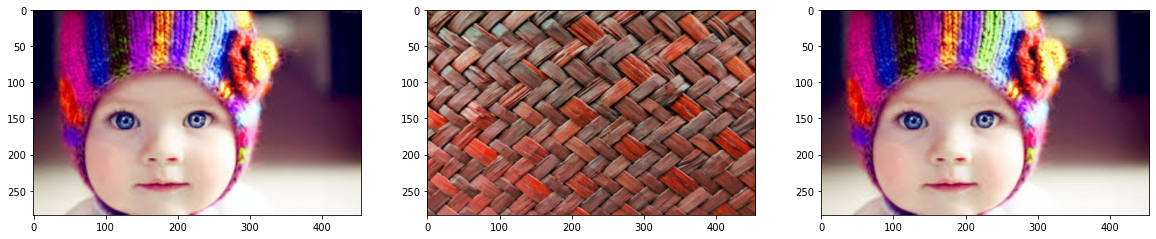

In [35]:
import base64
import os
from urllib.parse import quote as urlquote

from flask import Flask, send_from_directory
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State
import json

HTML_IMG_SRC_PARAMETERS = 'data:image/png;base64, '


# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Run ngrok to tunnel Dash app port 8050 to the outside world. 
### This command runs in the background.
get_ipython().system_raw('./ngrok http 8050 &')

### Get the public URL where you can access the Dash app. Copy this URL.
print('PUBLIC IP.....')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

UPLOAD_DIRECTORY = "./"

if not os.path.exists(UPLOAD_DIRECTORY):
    os.makedirs(UPLOAD_DIRECTORY)


# Normally, Dash creates its own Flask server internally. By creating our own,
# we can create a route for downloading files directly:
server = Flask(__name__)
app = dash.Dash(server=server)


@server.route("/download/<path:path>")
def download(path):
    """Serve a file from the upload directory."""
    return send_from_directory(UPLOAD_DIRECTORY, path, as_attachment=True)

def uploaded_files():
    """List the files in the upload directory."""
    files = []
    for filename in os.listdir(UPLOAD_DIRECTORY):
        path = os.path.join(UPLOAD_DIRECTORY, filename)
        if os.path.isfile(path):
            files.append(filename)
    return files


def file_download_link(filename):
    """Create a Plotly Dash 'A' element that downloads a file from the app."""
    location = "/download/{}".format(urlquote(filename))
    return html.A(filename, href=location)

def save_file(name, content):
    full_path = os.path.join(UPLOAD_DIRECTORY, name)
    """Decode and store a file uploaded with Plotly Dash."""
    data = content.encode("utf8").split(b";base64,")[1]
    with open(full_path, "wb") as fp:
        fp.write(base64.decodebytes(data))
    return full_path

def display_original_images(contents, filename):
    print('display_original_images ....')
    return html.Div([                    
        html.H5(filename),
        # HTML images accept base64 encoded strings in the same format
        # that is supplied by the upload
        html.Img(src=contents,style={'height':'50%', 'width':'50%'}),    
    ])

slider_labels = ['Default','Small','Large','Max']
content_weight_data = [1,2,3,4]
style_weight_data = [3,4,5,6]
learning_weight_data=[3,30,300,600]
epochs_data=[10,2000,3000,4000]
show_every_data=[10,800,1000,1500]


app.layout = html.Div(
    [
        html.H1("Pickup your Images"),
        html.H2("Upload Images To Style"),
        dcc.Upload(
            id="upload-data",
            children=html.Div(
                ["Drag and drop or click to select a file to upload."]
            ),
            style={
                "width": "100%",
                "height": "60px",
                "lineHeight": "60px",
                "borderWidth": "1px",
                "borderStyle": "dashed",
                "borderRadius": "5px",
                "textAlign": "center",
                "margin": "10px",
            },
            multiple=True,
        ),
     
        html.Div(id='content_style_radio',
            children=[
              dcc.RadioItems(
                id= 'content-radio',
                options=[{'label': i, 'value': i} for i in ['Content', 'Style']],                
                ),
              dcc.RadioItems(
              id= 'style-radio',
              options=[{'label': i, 'value': i} for i in ['Content', 'Style']],              
              ),
            ]),

        html.Div(id='content_style_original_images'),      

        html.Div([
                  html.H5('Content Image Weight%'),
                  dcc.Slider(
                      id = 'content_weight_slider',
                      min = min(content_weight_data),
                      max = max(content_weight_data),
                      value = min(content_weight_data),
                      marks = { content_weight : label for content_weight,label in zip(content_weight_data,slider_labels) },
                      step=None
                  ),
                  html.H5('Style Image Weight%'),
                  dcc.Slider(
                      id = 'style_weight_slider',
                      min = min(style_weight_data),
                      max = max(style_weight_data),
                      value = max(style_weight_data),
                      marks = { style_weight : label for style_weight,label in zip(style_weight_data,slider_labels) },
                      step=None
                  ),
                  html.H5('Learning Rate'),
                  dcc.Slider(
                      id = 'learning_rate_slider',
                      min = min(learning_weight_data),
                      max = max(learning_weight_data),
                      value = min(learning_weight_data),
                      marks = { learning_weight : label for learning_weight,label in zip(learning_weight_data,slider_labels) },
                      step=None
                  ),
                  html.H5('Repitions '),
                  dcc.Slider(
                      id = 'epochs_slider',
                      min = min(epochs_data),
                      max = max(epochs_data),
                      value = min(epochs_data),
                      marks = { epochs_weight : label for epochs_weight,label in zip(epochs_data,slider_labels) },
                      step=None
                  ),
                  html.H5('Print Inner Images Interval'),
                  dcc.Slider(
                      id = 'show_every_slider',
                      min = min(show_every_data),
                      max = max(show_every_data),
                      value = min(show_every_data),
                      marks = { show_every_weight : label for show_every_weight,label in zip(show_every_data,slider_labels) },
                      step=None
                  )

                 ]),
     
        html.Button('Start Styling', id='startBtn'),
        # CACHING INNER IMMGES
        #html.Div(id='cached_inner_images', style={'display': 'none'}),
        dcc.Store(id='cached_inner_images', storage_type='local'),
     
        html.Div(id='target_images'),     
        html.Div([
                  html.H5('Target Images'),
                  dcc.Slider(
                      id = 'target_images_slider',
                      min = 1,
                      max = 6,
                      value = 1,
                      marks = { target_image_index : target_image_index for target_image_index in range(6) },
                      step=None
                  ),
                 ])
        
        #html.H2("File List"),
        #html.Ul(id="file-list"),
     
    ],
    style={"max-width": "500px"},
)

#app.config['suppress_callback_exceptions']=True

images_path = [''] * 2

@app.callback(
    Output("content_style_original_images", "children"),
    [Input("upload-data", "filename"), 
     Input("upload-data", "contents"),]
)
def update_output(uploaded_filenames, uploaded_file_contents):
    """Save uploaded files and regenerate the file list."""
    i = 0
    children  = []
    if uploaded_filenames is not None and uploaded_file_contents is not None:
        for name, data in zip(uploaded_filenames, uploaded_file_contents):
            images_path[i] = save_file(name, data)
            print('uploaded image index: ',i,' At Path: ',images_path[i])
            children.append( display_original_images(data, name))
            i+=1
    #print('update_output called with {}, {} , {} '.format(uploaded_filenames,uploaded_file_contents,content_style_images_children))
    return children

@app.callback(
    #Output("file-list", "children"),
    [Output("target_images", "children"),
    Output('cached_inner_images', 'data')],    
    [Input('startBtn', 'n_clicks'),
     Input('content-radio','value'),
     Input('style-radio','value'),
     Input('content_weight_slider','value'),
     Input('style_weight_slider','value'),
     Input('learning_rate_slider','value'),
     Input('epochs_slider','value'),
     Input('show_every_slider','value'),
     Input('target_images_slider','value')],
     [State('cached_inner_images', 'data')]
)
def init_parameters(no_startBtn_click,selected_content,selected_style,content_weight_slider,style_weight_slider,learning_rate_slider,
                    epochs_slider,show_every_slider,target_images_slider,cached_inner_images):
    
    #HANDLE INNER IMAGES SLIDER
    if( target_images_slider is not None and cached_inner_images is not None):
      #inner_images = json.loads(cached_inner_images)
      print('Target Images Slider Index : {} , cached_inner_images: {} '.format(target_images_slider ,cached_inner_images ))
      return html.Img(src=HTML_IMG_SRC_PARAMETERS + numpy_to_b64(cached_inner_images[target_images_slider]),style={'height':'50%', 'width':'50%'}) , cached_inner_images

    # HANDLE CLICK
    if( no_startBtn_click is not None and no_startBtn_click > 0 ):
      target, cached_inner_images = RunModel(images_path[0],images_path[1],
                                      content_weight_slider,(10 ** style_weight_slider),(learning_rate_slider/1000),epochs_slider,show_every_slider )
      print(' clicks {} , cached inner_images : {} '.format(no_startBtn_click, cached_inner_images))
      return html.Img(src=HTML_IMG_SRC_PARAMETERS + numpy_to_b64(target),style={'height':'50%', 'width':'50%'}) , cached_inner_images

    #HANDLE RADIO SELECTION
    if( selected_content is not None ):
      print('Selected Content :',selected_content)

    #HANDLE RADIO SELECTION
    if( selected_style is not None ):
      print('Selected Style :',selected_style)

    #HANDLE WEIght SLIDER
    if( content_weight_slider is not None ):
      print('Content Weight Slider :',content_weight_slider)

    #HANDLE STYLE SLIDER
    if( style_weight_slider is not None ):
      print('Style Weight Slider :', (10 ** style_weight_slider)  )

    #HANDLE STYLE SLIDER
    if( learning_rate_slider is not None ):
      print('Learning Rate Slider :', (learning_rate_slider/1000)  )

    #HANDLE EPOCHS SLIDER
    if( epochs_slider is not None ):
      print('Epochs Slider :', epochs_slider  )

    #HANDLE SHOW EVERY SLIDER
    if( show_every_slider is not None ):
      print('Showevery Slider :', show_every_slider  )
   

"""
for i in images_path:
  @app.callback(Output('display-selected-values', 'children'),
              [Input('{}-style-content-radio'.format(i), 'value')],)
  def update_selected_radio(something):
    return html.H1(something)


@app.callback(
    Output('display-selected-values', 'children'),
    [Input('{}-style-content-radio'.format(os.path.splitext(filename)[0]), 'value') for filename in images_path] )
def handle_radio_selection(selected_content):
  print('Selected content ',selected_content)
  return selected_content

 files = uploaded_files()
if len(files) == 0:
    return [html.Li("No files yet!")]
else:
    return [html.Li(file_download_link(filename)) for filename in files]
"""

if __name__ == "__main__":
    app.run_server(debug=False, port=8050)